![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
import math
import matplotlib.pyplot as plt

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

A continuación definimoslas funciones para ejecutar el árbol de clasificación manualmente, cálculo de gini, gini impurity, best split, tree grow y tree predict:

In [6]:
# Gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    

# Gini Impurity
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_


# Función mejor corte
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Función para crecer el árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Función para predecir:

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

#### Ejecución del árbol manual y calculo de accuracy sobre datos de prueba

In [7]:
# Probamos varios max_depth para analizar cual es el de mejor accuracy

accuracy_list = []

for i in range(1, 10):
    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=i, num_pct=10)
    y_pred = tree_predict(X_test, tree)
    accuracy_list.append((i, accuracy_score(y_test, y_pred)))

accuracy_list

[(1, 0.858256351039261),
 (2, 0.858256351039261),
 (3, 0.8778868360277137),
 (4, 0.8810623556581986),
 (5, 0.8879907621247113),
 (6, 0.8830831408775982),
 (7, 0.8827944572748267),
 (8, 0.8784642032332564),
 (9, 0.8755773672055427)]

Podemos observar que el de mayor accuracy es 5, procederemos a formalizar el modelo con 5 de max_depth, realizar las predicciones sobre los datos de prueba (X_test) y luego obtener el accuracy:

In [8]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)
y_pred = tree_predict(X_test, tree)
acc_mod_ad_manual = accuracy_score(y_test, y_pred)
acc_mod_ad_manual

0.8879907621247113

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [9]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [10]:
# Construcción un árbol de decisión para cada muestra boostrap
n_B = 10

# Definición de modelo DecisionTreeClassifier
treeclasf = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_ = X_train.iloc[sample, ]
    y_train_ = y_train.iloc[sample, ]
    treeclasf.fit(X_train_, y_train_)
    y_pred.iloc[:,i] = treeclasf.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,0,0,0,0,0,0,0,0,0,0
326011,0,0,0,0,0,0,0,0,0,0
242354,1,1,1,1,1,1,1,1,1,1
266376,1,1,1,1,1,1,1,1,1,1
396954,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
144298,1,0,1,1,0,0,1,1,1,1
364521,1,1,1,1,1,1,1,1,1,1
120072,1,1,1,1,1,1,1,1,1,1
99878,0,0,0,0,0,0,0,0,0,0


In [11]:
# Votación mayoritaria
y_pred_ = (y_pred.sum(axis=1) >= (10 / 2)).astype(np.int)
acc_mod_bag_manual = accuracy_score(y_test, y_pred_)
acc_mod_bag_manual

0.8533487297921478

Para este punto procedimos a realizar un modelo bagging manualmente utilizando 10 árboles de clasificación, primero calculamos las muestras bootstrap (muestro aleatorio con repetición) para luego calcular un árbol de decisión para cada muestra, utilizamos los datos de prueba para realizar la predicción (se utiliza votación mayoritaria para determinar el resultado) y finalmente, calcular el accuracy score, lo que nos da como resultado **85.33% de accuracy**.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [12]:
bagclasf = BaggingClassifier(DecisionTreeClassifier(),
                             max_features =int(math.log2(9)),
                             n_estimators=10,
                             bootstrap=True, 
                             oob_score=True, 
                             random_state=1)

bagclasf.fit(X_train, y_train)
y_pred = bagclasf.predict(X_test)
acc_mod_bag_sklearn = accuracy_score(y_test, y_pred)
acc_mod_bag_sklearn

0.8666281755196305

Para este caso utilizamos la librería sklearn para realizar un modelo bagging de 10 árboles, en esta caso particular al entrenar cada árbol sobre cada muestra bootstrap definimos un máximo de variables a escoger de log2 del total de variables, al final se realiza la predicción sobre los datos de prueba arrojando como resultado un **accuracy de 86.66%**.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [30]:
# Celda 4
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_mod_rf_sklearn = accuracy_score(y_test, y_pred)
acc_mod_rf_sklearn

0.8438221709006929

### Conclusiones punto 4

Utilizamos el modelo Random Forest de la librería sklearn para predecir si el precio de un automovil es alto o no. Inicialmente utilizamos los parámetros por defecto del clasificador, es decir, entrenamos al modelo usando 100 árboles (n_estimators) y la raíz cuadrada del total de features como número de variables a considerar por árbol (max_features). Ajustando el modelo bajo dichas consideraciones obtuvimos un acurracy 0.8443 en la muestra test.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [28]:
# Celda 5

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(5, 250, 5)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


Text(0, 0.5, 'Accuracy')

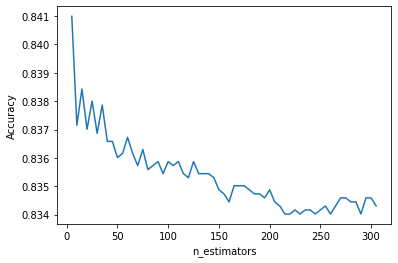

In [38]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

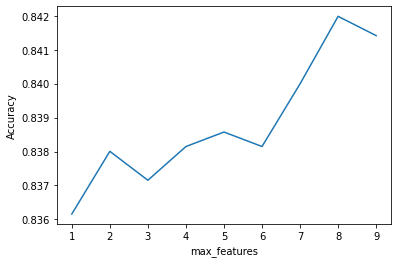

In [19]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_cols = X.columns
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=10, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

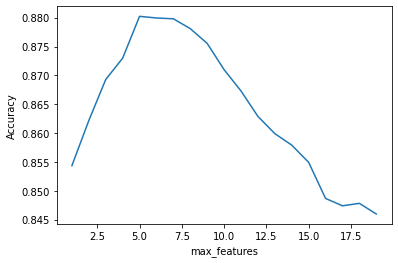

In [20]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 20, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf = RandomForestClassifier(n_estimators=10, max_features=8, max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [21]:
# Selección de mejores parámetros
clf = RandomForestClassifier(n_estimators=10, max_features=8, max_depth=5, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_rf_sklearn = accuracy_score(y_test, y_pred)
acc_rf_sklearn

0.8882794457274826

### Conclusiones punto 5

Luego de calibrar los parámetros n_estimators, max_features y max_depth del modelo Randon Forest para clasificación obtuvimos un acurracy 0.8882 en la muestra test. Analizando cada uno de estos parámetros vemos que para n_estimators el performance se degrada luego de que el modelo supera los 10 árboles, es decir, esta es la cantidad óptima de arboles para alcanzar el mejor poder predictivo posible. Para max_features vemos que el rendimiento óptimo se alcanza utilizando 8 variables predictoras, es decir, usar más o menos variables se traduce en un nivel de pureza inferior. Para el parámetro max_depth alcanzamos el rendimiento más alto limitando la profundidad del árbol en 5, es decir, este es el punto en el que las hojas alcanzan su nivel más alto de pureza.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [39]:
!pip install xgboost

In [22]:
# Celda 6
# Importación y definición de modelo XGBClassifier
from xgboost import XGBClassifier
clf = XGBClassifier()
clf


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

In [32]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_mod_xg_sklearn = accuracy_score(y_pred, y_test)
acc_mod_xg_sklearn

0.8432448036951501

Al implementar el modelo XGBoost de clasificación de la librería sklearn con los parámertros por default obtenemos un Accuracy score que es superior al modelo Random Forest en las mismas condiciones. Sin embargo, tiene un valor menor al modelo de Random Forest que ya se encuentra calibrado.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

Text(0, 0.5, 'Accuracy')

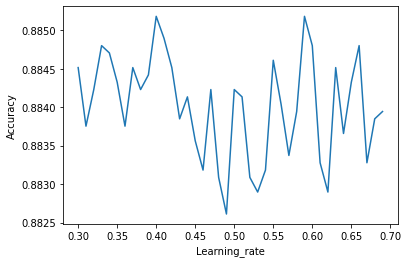

In [24]:
# Celda 7
# Creación de lista de valores para iterar sobre diferentes valores de learning rate
rate_range=[]
def range_with_floats(start, step, stop):
    while stop > start:
        yield start
        start += step
for i in range_with_floats(0.3, 0.01, 0.7):
  rate_range.append(i)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de learning rate
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for rate in rate_range:
    clf = XGBClassifier(colsample_bytree=1, n_estimators=10, max_depth=5,
              gamma=0, learning_rate=rate, n_jobs=1, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_depths
plt.plot(rate_range, accuracy_scores)
plt.xlabel('Learning_rate')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

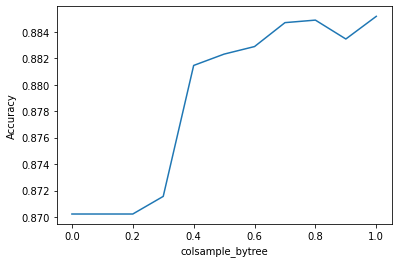

In [25]:
# Creación de lista de valores para iterar sobre diferentes valores de learning rate
bytree_range=[]
def range_with_floats(start, step, stop):
    while stop > start:
        yield start
        start += step
for i in range_with_floats(0.0, 0.1, 2.0):
  bytree_range.append(i)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de learning rate
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for bytree in bytree_range:
    clf = XGBClassifier(colsample_bytree=bytree, n_estimators=10, max_depth=5,
              gamma=0, learning_rate=0.4, n_jobs=1, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

  # Gráfica del desempeño del modelo vs la cantidad de max_depths
plt.plot(bytree_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

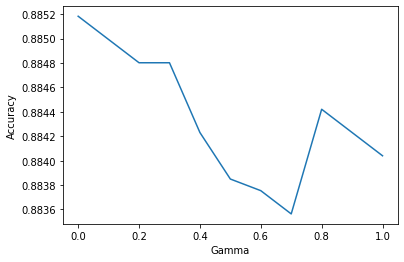

In [26]:
# Creación de lista de valores para iterar sobre diferentes valores de learning rate
gamma_range=[]
def range_with_floats(start, step, stop):
    while stop > start:
        yield start
        start += step
for i in range_with_floats(0.0, 0.1, 1.0):
  gamma_range.append(i)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de learning rate
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for gamma in gamma_range:
    clf = XGBClassifier(colsample_bytree=1, n_estimators=10, max_depth=5,
              gamma=gamma, learning_rate=0.4, n_jobs=1, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

  # Gráfica del desempeño del modelo vs la cantidad de max_depths
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

In [33]:
# Definición del modelo con los parámetros colsample_bytree=1, gamma=0.5 y learning_rate=0.2 
clf = XGBClassifier(colsample_bytree=1, gamma=0, learning_rate=0.4, n_jobs=1, random_state=1, n_estimators=10, max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_mod_xg_param_sklearn = accuracy_score(y_pred, y_test)
acc_mod_xg_param_sklearn

0.8888568129330254

Al realizar la calibración de los parámetros del modelo XGBoost podemos obtener un valor ligeramente superior al modelo calibrado de Random Forest. Sin embargo, es posible debido a que se mantienen los valores calibrados de estimadores y profundidad. En caso contrario, con valores por default de dichos parámetros se obtiene un accuracy score más bajo que el modelo de Random Forest. El parámetro de Learning rate, que se mantiene entre 0 y 1, presenta un comportamiento creciente, que después de 0.2 es prácticamente constante. El parámetro Colsample_bytree tiene una tendencia creciente que obtiene el mayor accuracy score en 1. Finalmente, el parámetro gamma tiene un comportamientto decreciente, donde el mayor valor del accuracy score está en el gamma=0.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

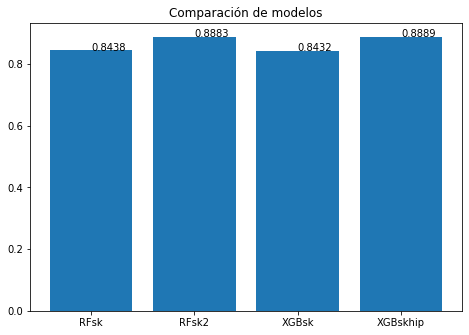

In [40]:
# Celda 8

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = [#'DTMan', 'BAGMan','BAGsk', 
    'RFsk', 'RFsk2', 'XGBsk', 'XGBskhip']
ejeY = [
        round(acc_mod_rf_sklearn, 4), 
        round(acc_rf_sklearn, 4), round(acc_mod_xg_sklearn, 4),
        round(acc_mod_xg_param_sklearn, 4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

Finalmente, analizamos los modelos de Random Forest y XGBoost, el indicador accuracy utilizado para la comparación del modelo nos muestra que el modelo con mayor desempeno es XGBoost con calibración de parámetros con 88.89% de accuracy y el modelo con menor desempeno es XGBoost sin calibración de parámetros: 84.32%. Una de las ventajas de realizar calibración de parámetros es precisamente la mejora en el indicador de 4.5% aproximadamente, aunque esto resulte en mayor tiempo de entrenamiento que se considera una desventaja.

Observamos tambien que el modelo de Random Forest con calibración de parámetros tiene un accuracy muy cercano al mejor modelo de XGBoost, en este caso podriamos decidir que modelo genera la predicción más rapido una vez el modelo este en producción.